# 今日のKaggle 0819
[Kaggleページ](https://www.kaggle.com/c/web-traffic-time-series-forecasting/data)

[参考ノート](https://www.kaggle.com/muonneutrino/wikipedia-traffic-data-exploration)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import re

## 選定理由
- 今回は賞金額の大きい順に選定しよう（画像処理系が多く、ノートを読んでもよくわからない）
- NYタクシーコンペ・従業員の満足度調査など色々発見するも、業界用語や文化の違いでよくわからないものばかり
- ということで消極的選択。

## コンペ概要
- この競争は常に複数の時系列の将来の値を予測するという問題に焦点を当てています。これは、常にこの分野で最も困難な問題の1つであったためです。より具体的には、ウィキペディアの約145,000の記事の将来のWebトラフィックを予測するという問題について、参加者が設計した最先端の方法をテストすることを目的としています。  この競争は2つのステージとして実行され、実際の将来のイベントの予測が含まれます。リーダーボードが履歴データに基づいているトレーニングステージがあり、その後に参加者が実際の将来のイベントで得点するステージが続きます。

- 要約
  - 第一ステージ: 過去のアクセスデータ（20150701~20161231)
  - 第二ステージ: 実際の未来予測(20170913~20171113)
  - ※コンペ期間: 20170901~20170912

## データセット
トレーニングデータセットは、約145,000の時系列で構成されます。これらの各時系列は、2015年7月1日から2016年12月31日までのさまざまなWikipedia記事の毎日のビューの数を表しています。トレーニング段階のリーダーボードは、2017年1月1日から3月までのトラフィックに基づいています2017年1月。

第2ステージでは、2017年9月1日までのトレーニングデータを使用します。コンテストの最終ランキングは、データセット内の各記事について、2017年9月13日から2017年11月13日までの毎日の視聴回数の予測に基づいています。これらの日付の予測を9月12日までに送信してください。

In [2]:
train = pd.read_csv('../Kaggle/web-traffic-time-series-forecasting/train_1.csv').fillna(0)
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


In [4]:
def get_language(page):
    res = re.search('[a-z][a-z].wikipedia.org',page)
    if res:
        return res[0][0:2]
    return 'na'

train['lang'] = train.Page.map(get_language)

from collections import Counter

print(Counter(train.lang))

Counter({'en': 24108, 'ja': 20431, 'de': 18547, 'na': 17855, 'fr': 17802, 'zh': 17229, 'ru': 15022, 'es': 14069})


## 7つの言語とメディアページがあります。ここで使用される言語は、英語、日本語、ドイツ語、フランス語、中国語、ロシア語、スペイン語です。 4つの異なる書記法（ラテン語、キリル文字、中国語、日本語）が処理されるため、URLの分析は困難になります。ここでは、さまざまなタイプのエントリのデータフレームを作成します。次に、すべてのビューの合計を計算します。データはいくつかの異なるソースから取得されているため、合計はビューの一部を二重にカウントする可能性があることに注意します。

In [5]:
lang_sets = {}
lang_sets['en'] = train[train.lang=='en'].iloc[:,0:-1]
lang_sets['ja'] = train[train.lang=='ja'].iloc[:,0:-1]
lang_sets['de'] = train[train.lang=='de'].iloc[:,0:-1]
lang_sets['na'] = train[train.lang=='na'].iloc[:,0:-1]
lang_sets['fr'] = train[train.lang=='fr'].iloc[:,0:-1]
lang_sets['zh'] = train[train.lang=='zh'].iloc[:,0:-1]
lang_sets['ru'] = train[train.lang=='ru'].iloc[:,0:-1]
lang_sets['es'] = train[train.lang=='es'].iloc[:,0:-1]

sums = {}
for key in lang_sets:
    sums[key] = lang_sets[key].iloc[:,1:].sum(axis=0) / lang_sets[key].shape[0]

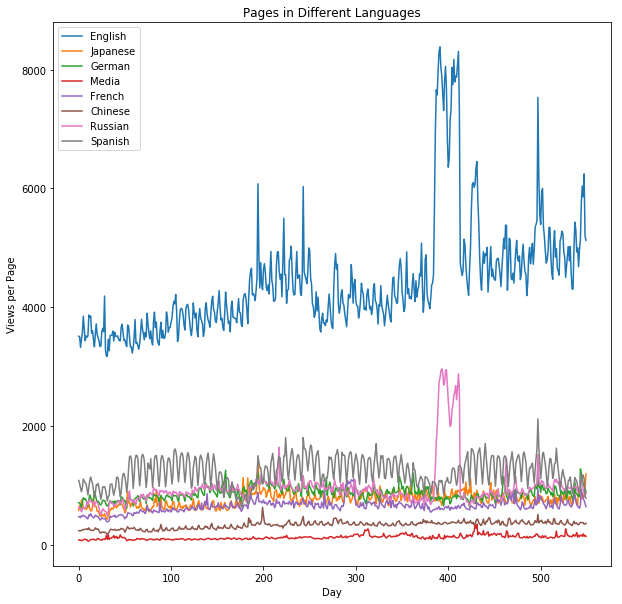

In [6]:
days = [r for r in range(sums['en'].shape[0])]

fig = plt.figure(1,figsize=[10,10])
plt.ylabel('Views per Page')
plt.xlabel('Day')
plt.title('Pages in Different Languages')
labels={'en':'English','ja':'Japanese','de':'German',
        'na':'Media','fr':'French','zh':'Chinese',
        'ru':'Russian','es':'Spanish'
       }

for key in sums:
    plt.plot(days,sums[key],label = labels[key] )
    
plt.legend()
plt.show()

## Wikipediaは米国を拠点とするサイトであるため、英語ではページあたりの表示回数がはるかに多くなっています。ここには予想以上に多くの構造があります。英語とロシアのプロットでは、400日頃（2016年8月頃）に非常に大きなスパイクが見られますが、2016年後半には英語のデータにさらにいくつかのスパイクが見られます。これは、8月の夏季オリンピックと選挙の影響です。我ら。 200日目付近の英語のデータにも奇妙な特徴があります。スペイン語のデータも非常に興味深いものです。そこには明確な周期的構造があり、約1週間の高速期間があり、6か月ごとに大きな落ち込みのように見えます。

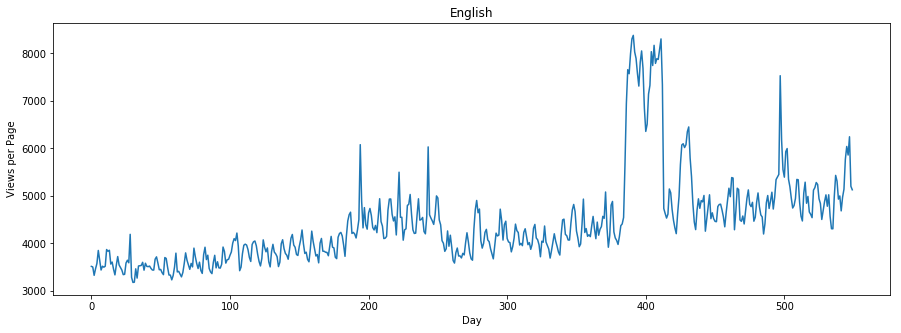

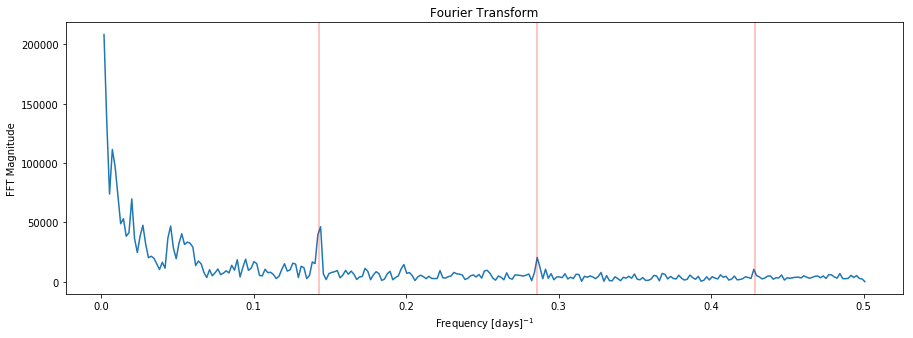

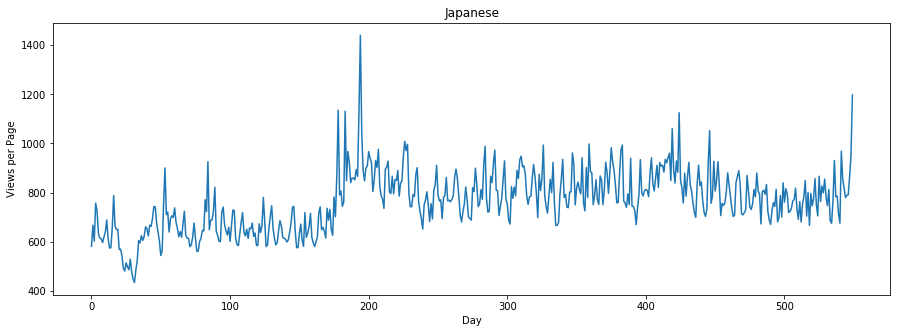

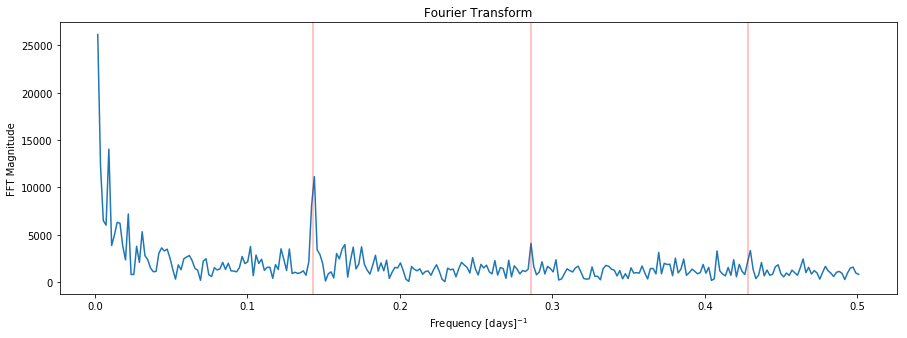

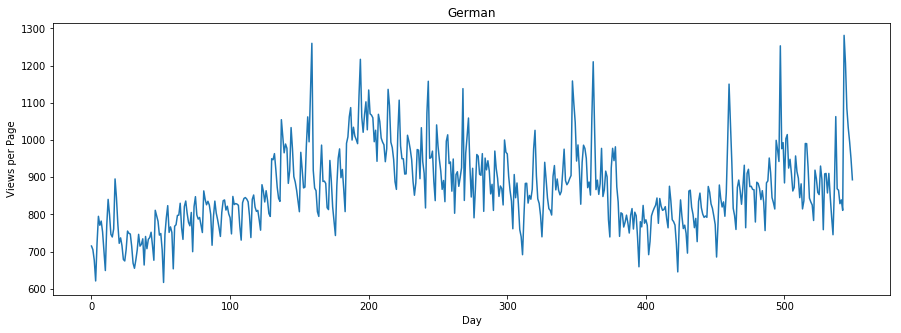

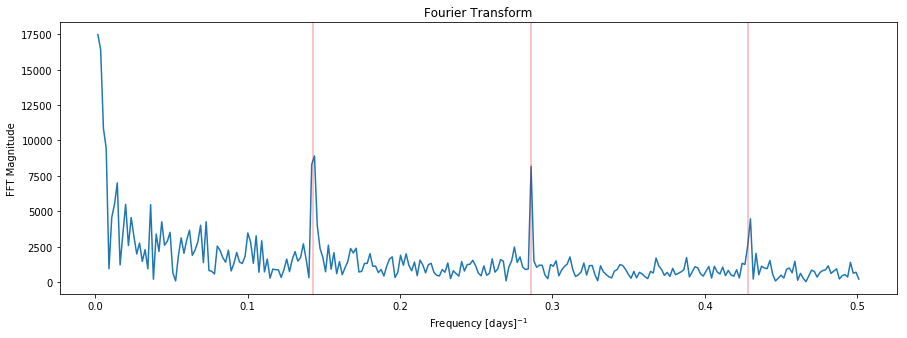

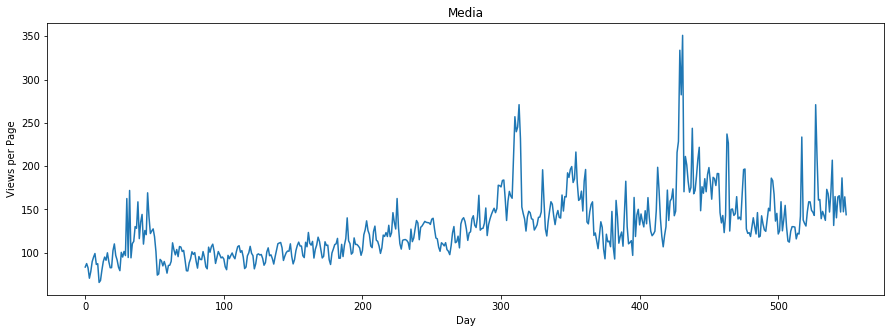

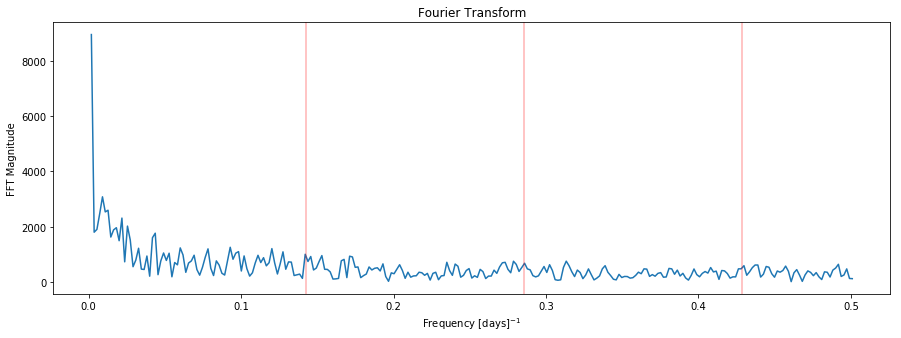

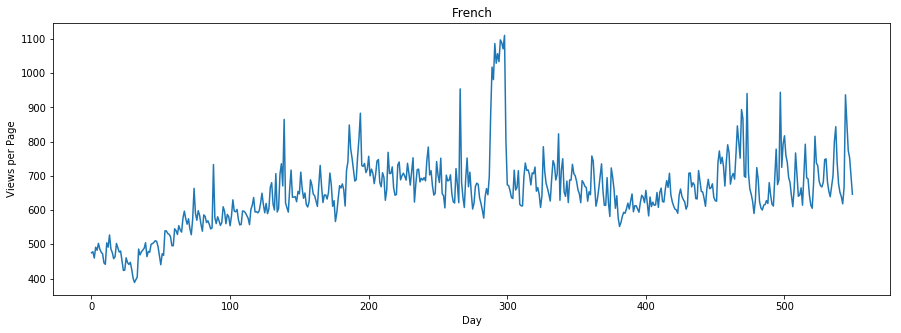

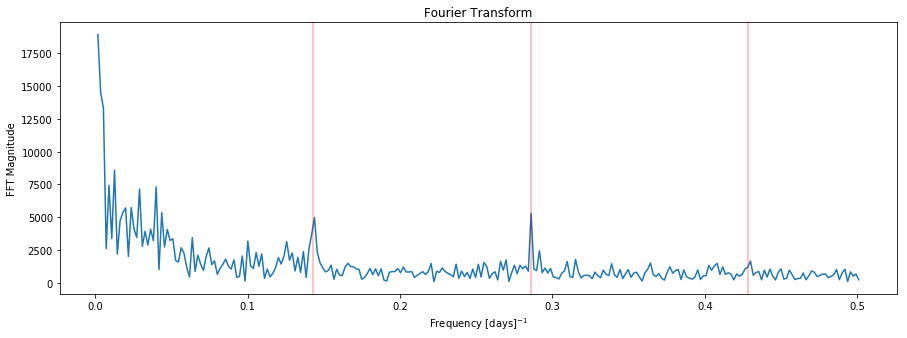

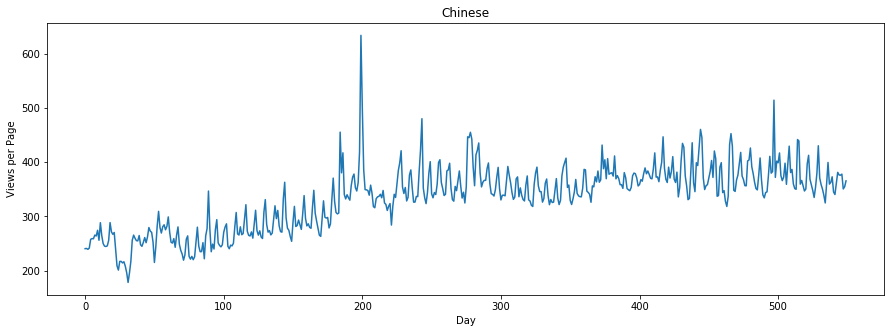

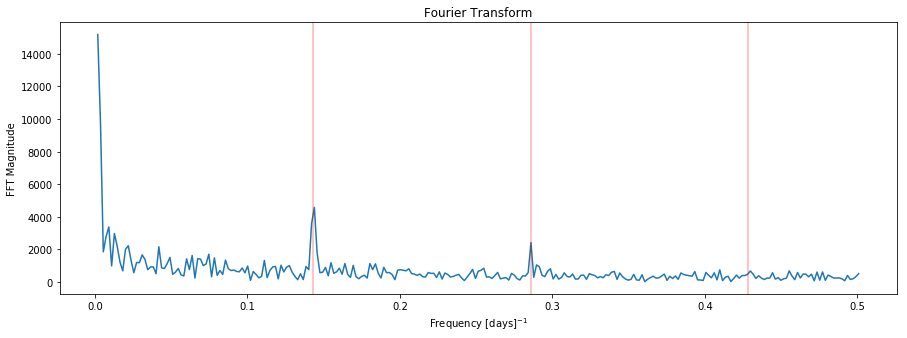

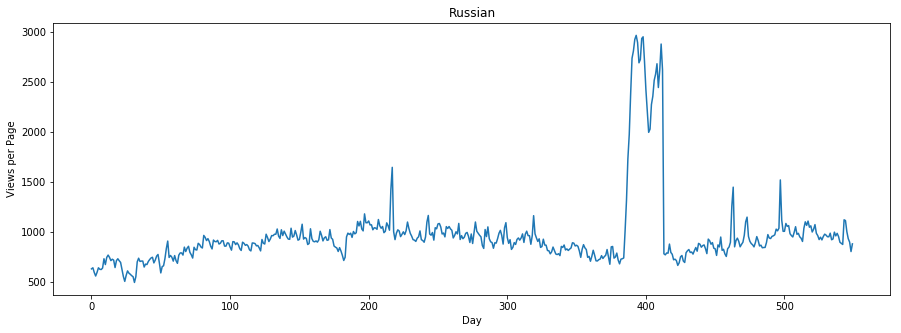

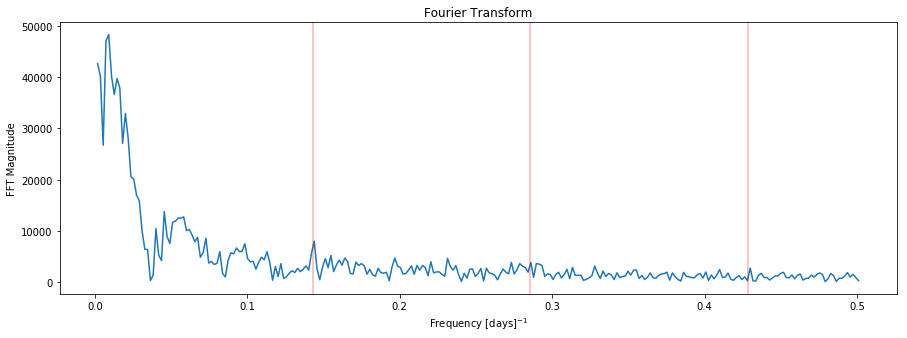

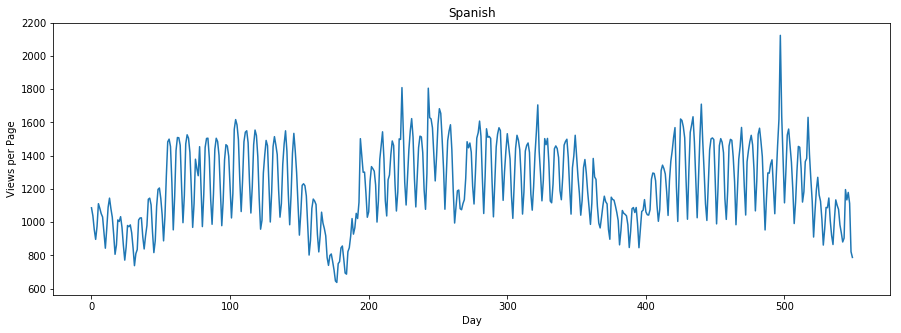

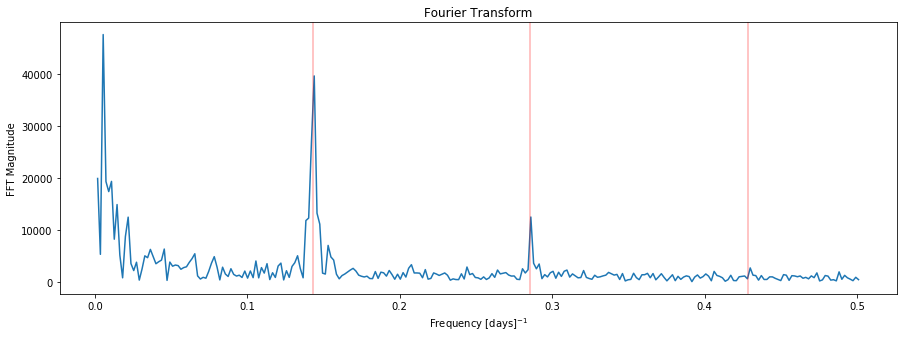

In [7]:
from scipy.fftpack import fft
def plot_with_fft(key):

    fig = plt.figure(1,figsize=[15,5])
    plt.ylabel('Views per Page')
    plt.xlabel('Day')
    plt.title(labels[key])
    plt.plot(days,sums[key],label = labels[key] )
    
    fig = plt.figure(2,figsize=[15,5])
    fft_complex = fft(sums[key])
    fft_mag = [np.sqrt(np.real(x)*np.real(x)+np.imag(x)*np.imag(x)) for x in fft_complex]
    fft_xvals = [day / days[-1] for day in days]
    npts = len(fft_xvals) // 2 + 1
    fft_mag = fft_mag[:npts]
    fft_xvals = fft_xvals[:npts]
        
    plt.ylabel('FFT Magnitude')
    plt.xlabel(r"Frequency [days]$^{-1}$")
    plt.title('Fourier Transform')
    plt.plot(fft_xvals[1:],fft_mag[1:],label = labels[key] )
    # Draw lines at 1, 1/2, and 1/3 week periods
    plt.axvline(x=1./7,color='red',alpha=0.3)
    plt.axvline(x=2./7,color='red',alpha=0.3)
    plt.axvline(x=3./7,color='red',alpha=0.3)

    plt.show()

for key in sums:
    plot_with_fft(key)

## このことから、スペイン語のデータには最も強い周期的特徴がありますが、他のほとんどの言語もある程度の周期性を示しています。何らかの理由で、ロシアとメディアのデータはあまり表示されていないようです。 1、1 / 2、および1/3週間の期間が現れる赤い線をプロットしました。周期的な特徴は主に1週間と1週間半であることがわかります。ブラウジングの習慣が週末と比較して平日に異なる場合があり、整数nのn /（1週間）の頻度でFFTのピークにつながるため、これは驚くべきことではありません。つまり、ページビューがまったくスムーズではないことがわかりました。日常的に一定の変動がありますが、突然発生する可能性のある大きな影響もあります。その日の世界で何が起こっているかについてより多くの情報を与えられない限り、モデルは突然のスパイクを予測することができないでしょう。1

In [8]:
def plot_entry(key,idx):
    data = lang_sets[key].iloc[idx,1:]
    fig = plt.figure(1,figsize=(10,5))
    plt.plot(days,data)
    plt.xlabel('day')
    plt.ylabel('views')
    plt.title(train.iloc[lang_sets[key].index[idx],0])
    
    plt.show()

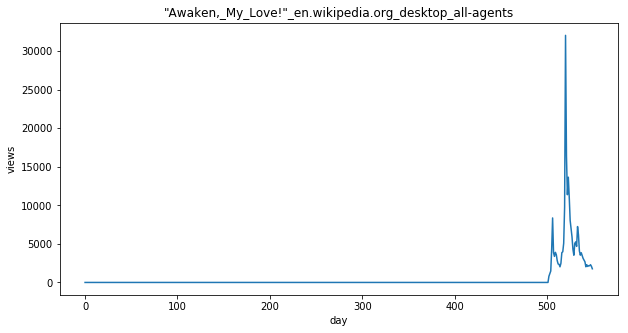

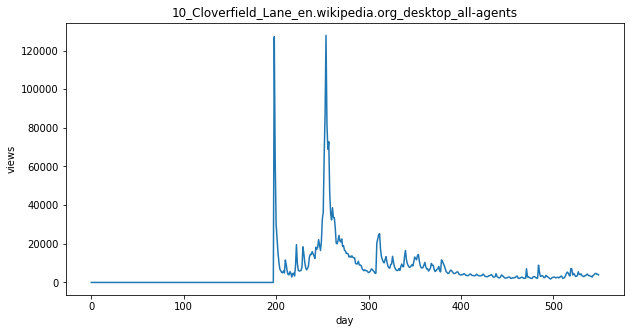

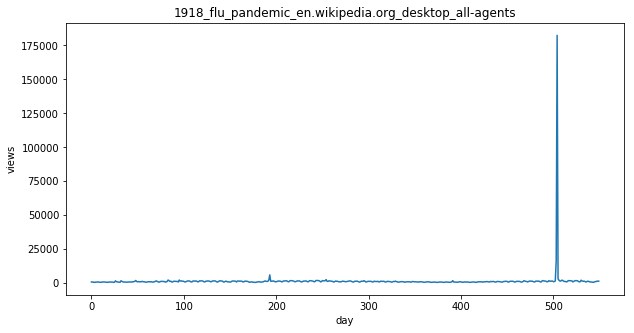

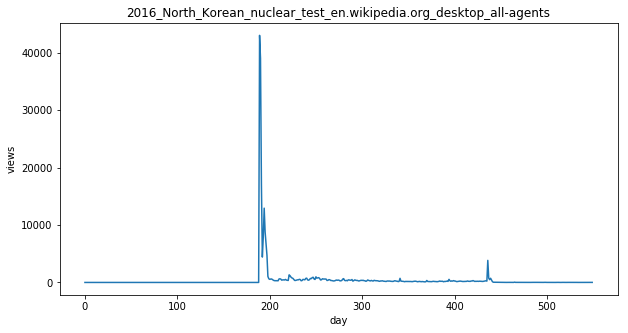

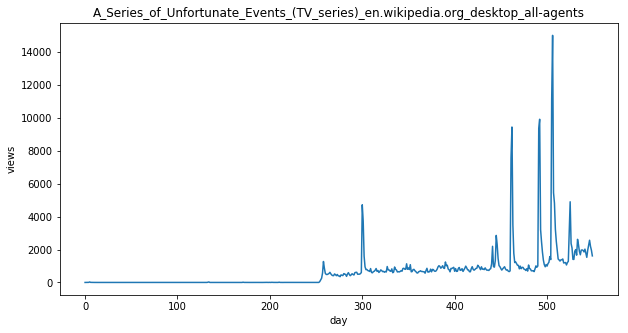

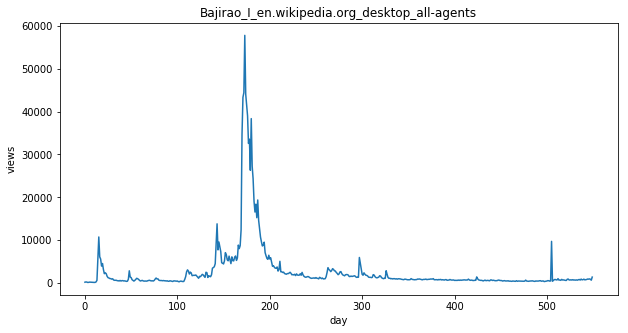

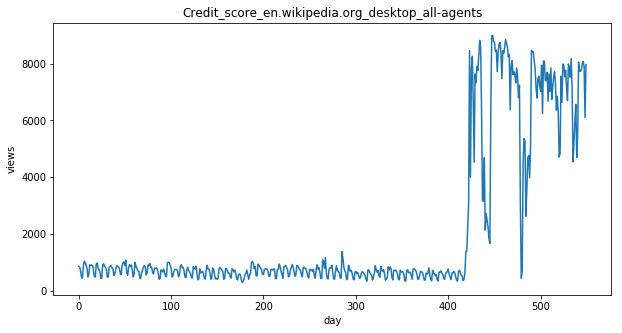

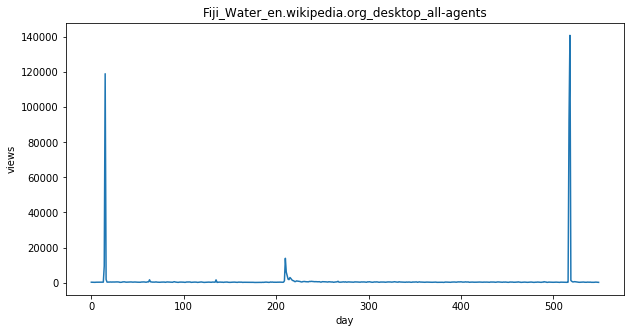

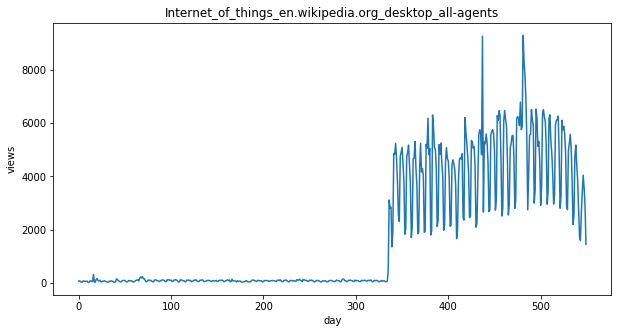

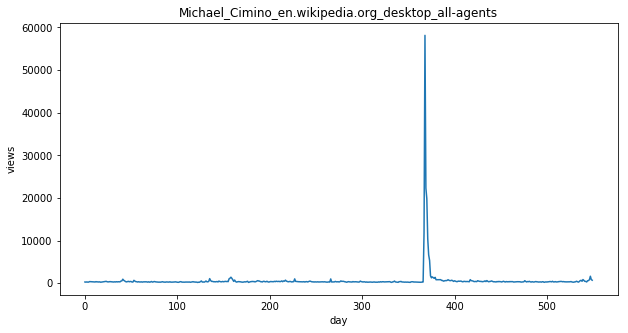

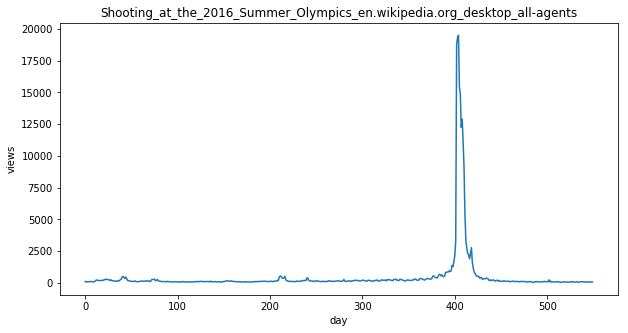

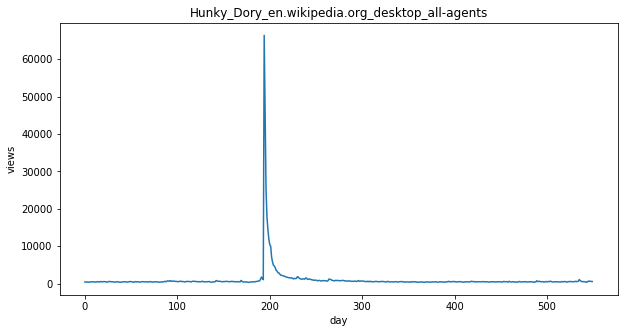

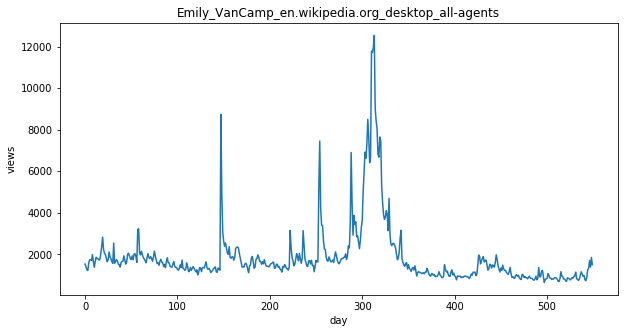

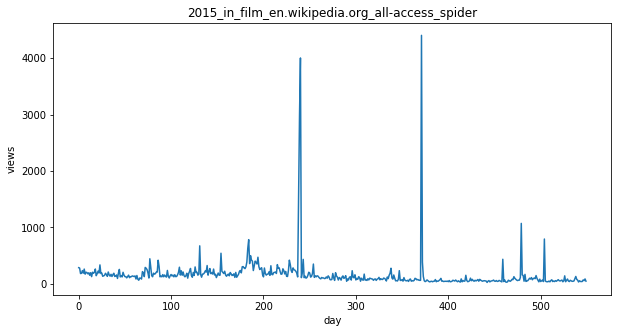

In [9]:
idx = [1, 5, 10, 50, 100, 250,500, 750,1000,1500,2000,3000,4000,5000]
for i in idx:
    plot_entry('en',i)

## これは、英語のデータよりもさらに極端な短期スパイクを示しています。これらの一部が平均に戻る前の1〜2日である場合は、データに問題があることを示している可能性があります。ほぼ確実に予測できない非常に短いスパイクに対処するために、中央値フィルターのようなものを使用してそれらを除去できます。しかし、ここでは非常に興味深いことがわかります。非常に強い周期構造が特定のページにのみ表示されることがわかります。最強の周期構造を示すプロットは、実際にはすべて共通点があります。それらはすべて、健康トピックと関係があるようです。毎週の構造は、医師に会ってウィキペディアに相談する人に関連している場合に意味があります。長い（約6か月）構造は、特にブラウザーの人口統計情報がない場合は説明が難しくなります。

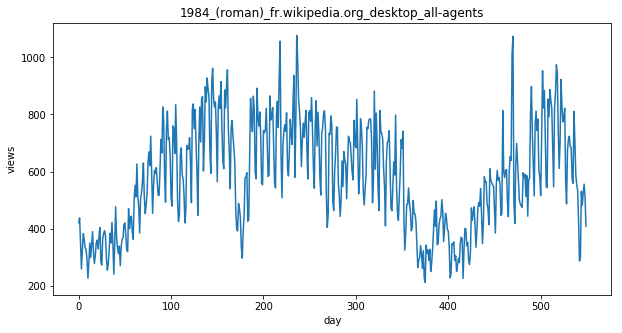

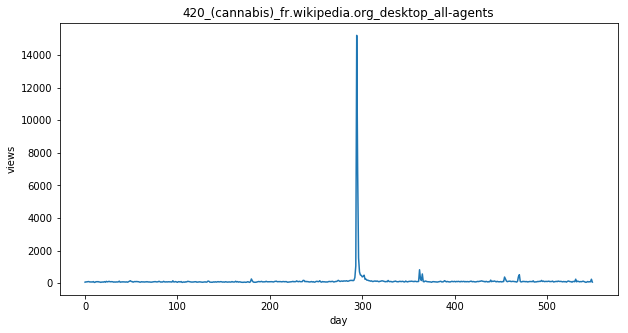

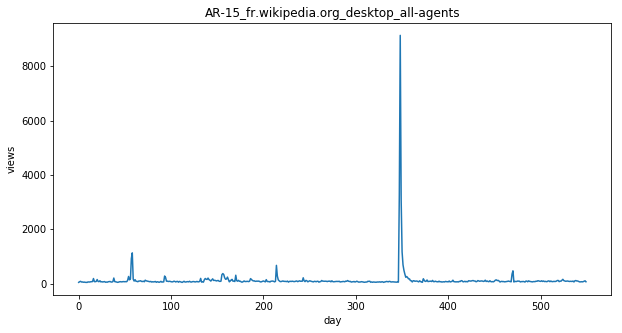

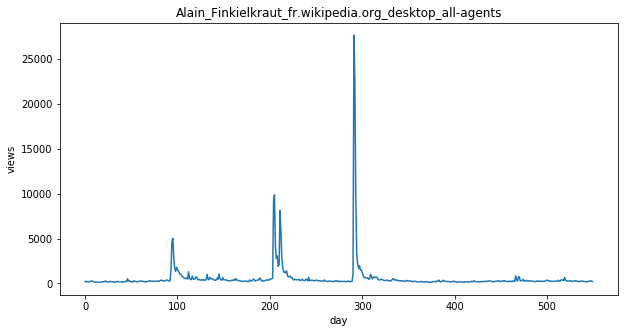

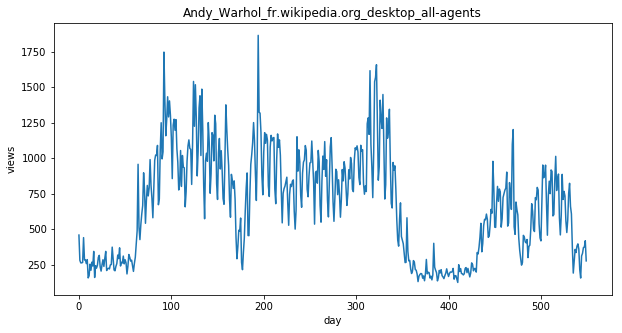

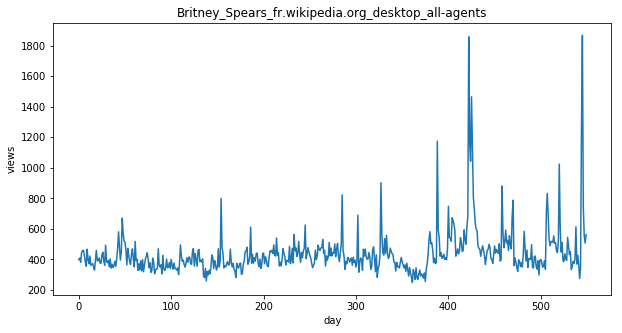

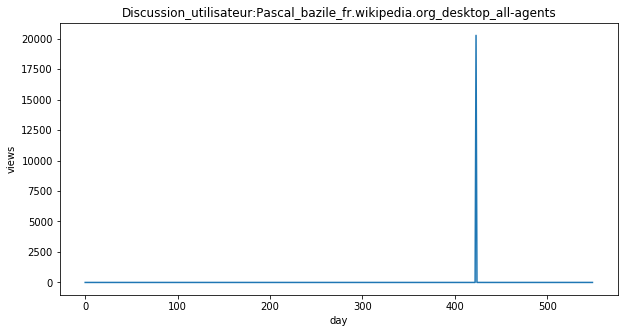

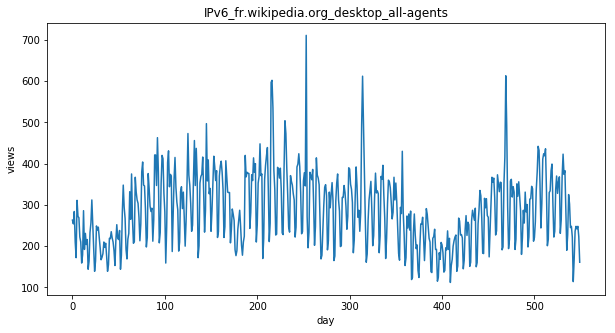

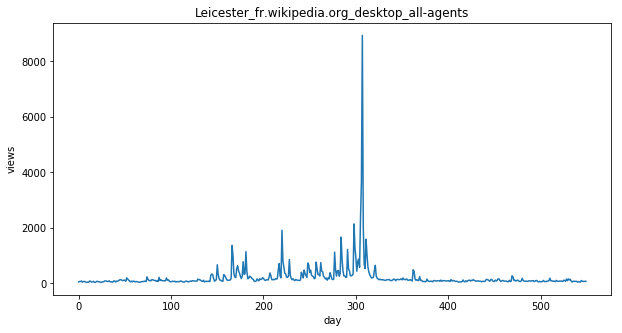

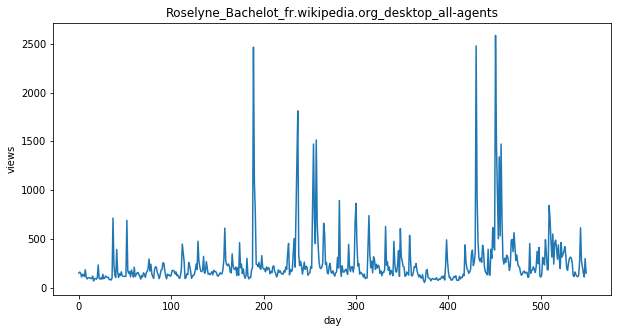

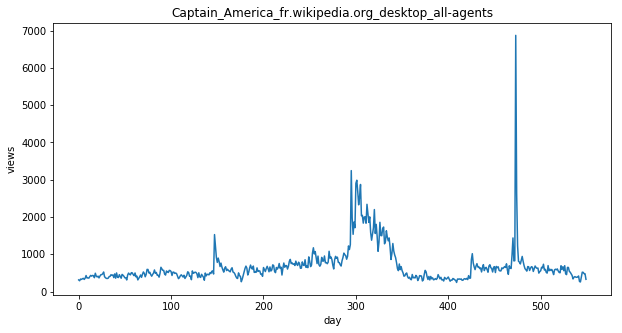

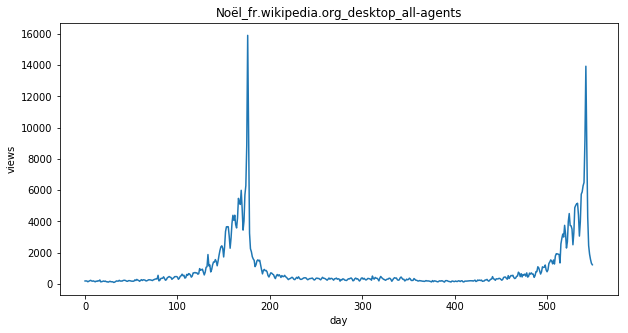

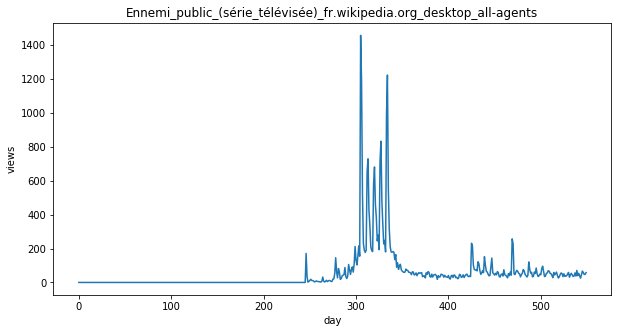

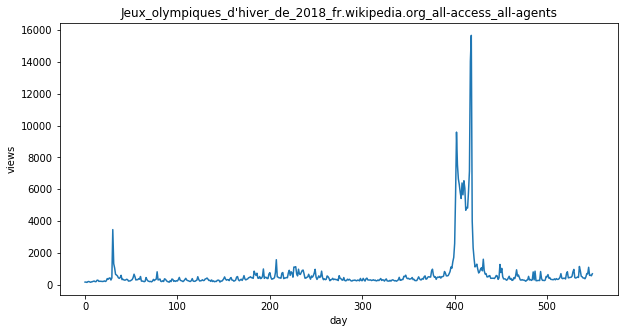

In [10]:
idx = [1, 5, 10, 50, 100, 250,500, 750,1001,1500,2000,3000,4000,5000]
for i in idx:
    plot_entry('fr',i)

In [11]:
# For each language get highest few pages
npages = 5
top_pages = {}
for key in lang_sets:
    print(key)
    sum_set = pd.DataFrame(lang_sets[key][['Page']])
    sum_set['total'] = lang_sets[key].sum(axis=1)
    sum_set = sum_set.sort_values('total',ascending=False)
    print(sum_set.head(10))
    top_pages[key] = sum_set.index[0]
    print('\n\n')

en
                                                    Page         total
38573   Main_Page_en.wikipedia.org_all-access_all-agents  1.206618e+10
9774       Main_Page_en.wikipedia.org_desktop_all-agents  8.774497e+09
74114   Main_Page_en.wikipedia.org_mobile-web_all-agents  3.153985e+09
39180  Special:Search_en.wikipedia.org_all-access_all...  1.304079e+09
10403  Special:Search_en.wikipedia.org_desktop_all-ag...  1.011848e+09
74690  Special:Search_en.wikipedia.org_mobile-web_all...  2.921628e+08
39172  Special:Book_en.wikipedia.org_all-access_all-a...  1.339931e+08
10399   Special:Book_en.wikipedia.org_desktop_all-agents  1.332859e+08
33644       Main_Page_en.wikipedia.org_all-access_spider  1.290204e+08
34257  Special:Search_en.wikipedia.org_all-access_spider  1.243102e+08



ja
                                                     Page        total
120336      メインページ_ja.wikipedia.org_all-access_all-agents  210753795.0
86431          メインページ_ja.wikipedia.org_desktop_all-agents  134147415

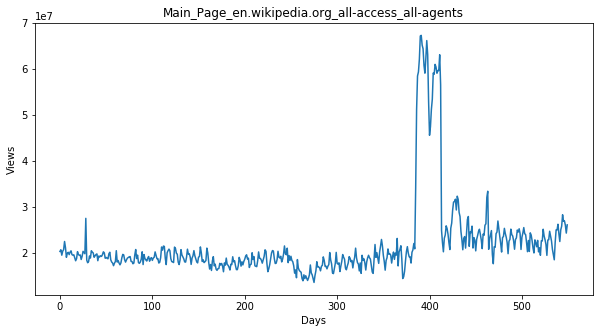

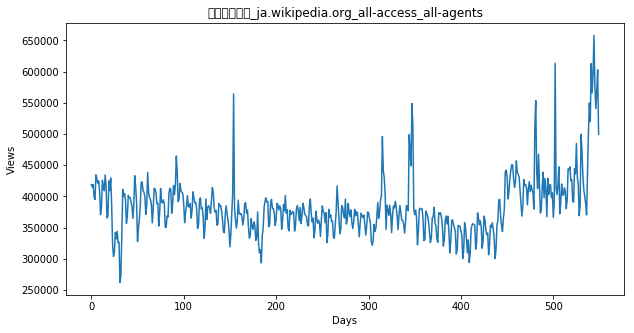

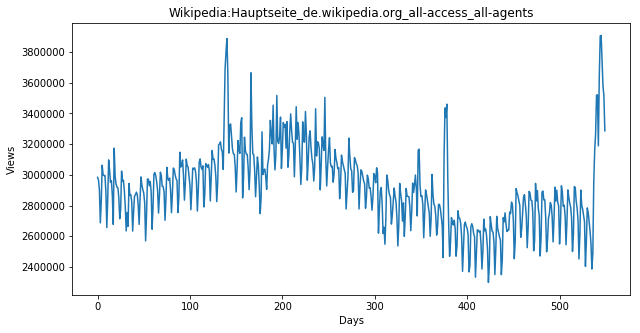

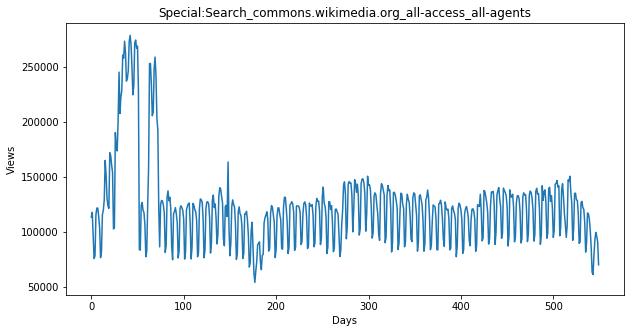

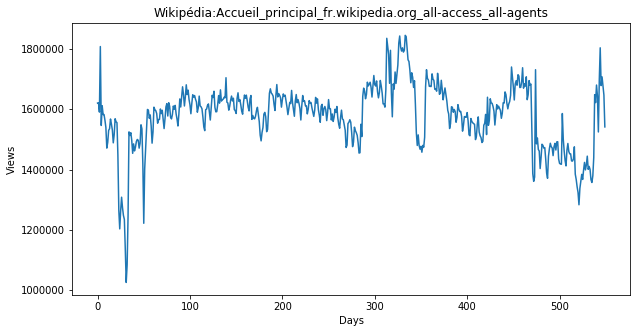

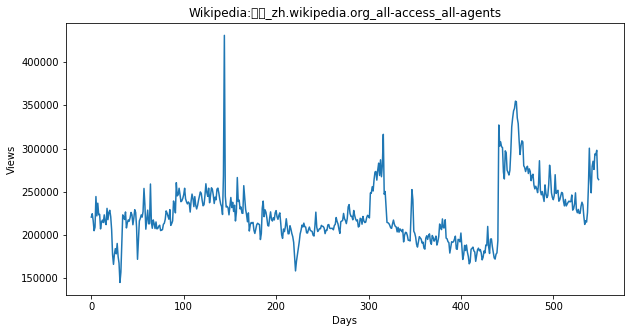

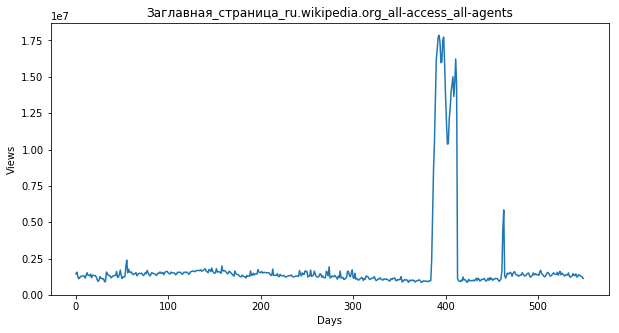

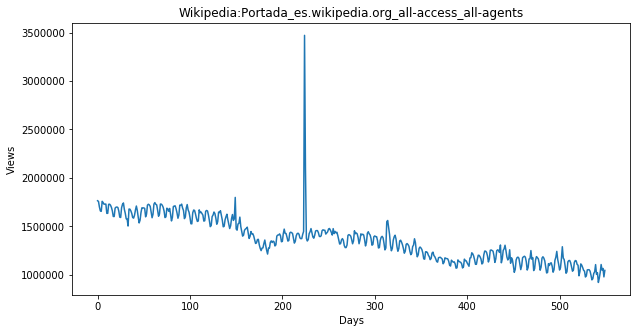

In [12]:
for key in top_pages:
    fig = plt.figure(1,figsize=(10,5))
    cols = train.columns
    cols = cols[1:-1]
    data = train.loc[top_pages[key],cols]
    plt.plot(days,data)
    plt.xlabel('Days')
    plt.ylabel('Views')
    plt.title(train.loc[top_pages[key],'Page'])
    plt.show()

## ここから学習・分析
その他の分析ツールstatsmodelsパッケージには、時系列分析を行うためのかなりの数のツールが含まれています。ここでは、各言語で最も閲覧されたページの自己相関と部分自己相関を示します。これらは両方とも、信号とそれ自体の遅延バージョンとの相関関係を示しています。各ラグで、部分的な自己相関は、短いラグで相関を削除した後、そのラグでの相関を表示しようとします。

## statsmodels
- [公式?:     https://www.statsmodels.org/stable/index.html](https://www.statsmodels.org/stable/index.html)  
- [Qlita:      https://qiita.com/innovation1005/items/b712ce54a7a697a9bf03](https://qiita.com/innovation1005/items/b712ce54a7a697a9bf03)

- 要約すると、線形回帰の学習モデルのようです。回帰直線を引くことも簡単そうなライブラリ。

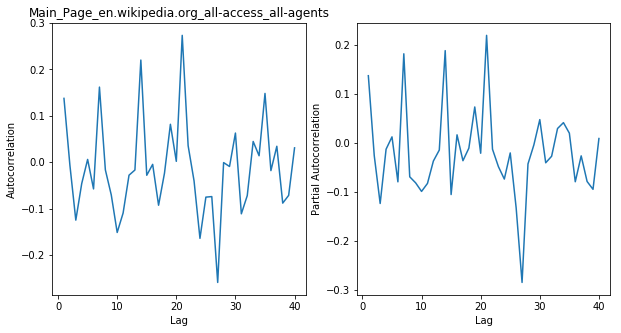

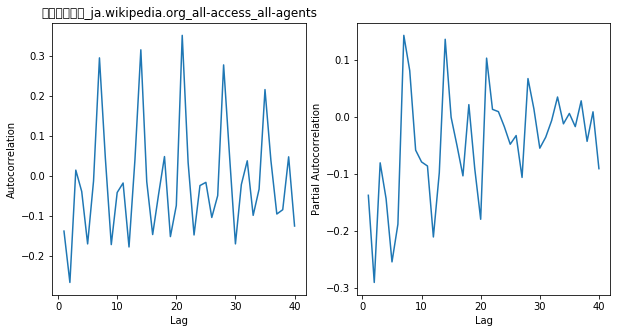

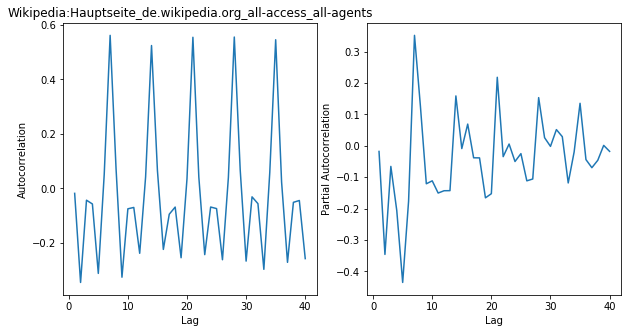

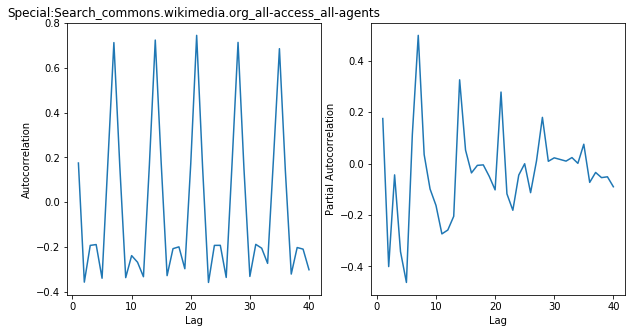

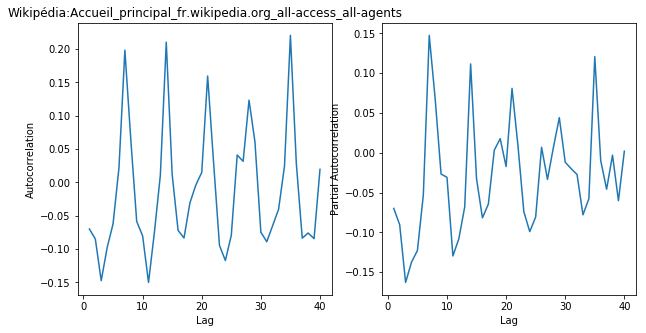

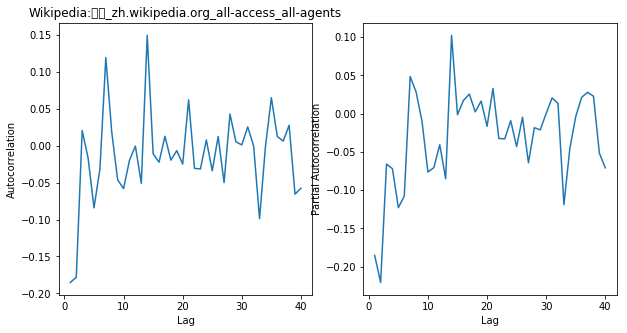

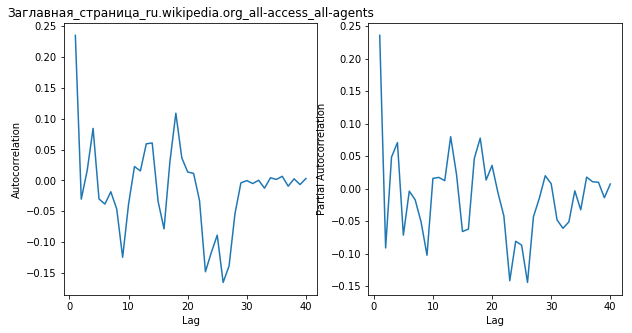

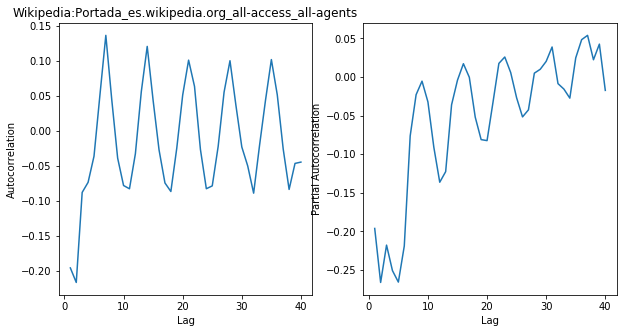

In [13]:
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf

for key in top_pages:
    fig = plt.figure(1,figsize=[10,5])
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    cols = train.columns[1:-1]
    data = np.array(train.loc[top_pages[key],cols])
    data_diff = [data[i] - data[i-1] for i in range(1,len(data))]
    autocorr = acf(data_diff)
    pac = pacf(data_diff)

    x = [x for x in range(len(pac))]
    ax1.plot(x[1:],autocorr[1:])

    ax2.plot(x[1:],pac[1:])
    ax1.set_xlabel('Lag')
    ax1.set_ylabel('Autocorrelation')
    ax1.set_title(train.loc[top_pages[key],'Page'])

    ax2.set_xlabel('Lag')
    ax2.set_ylabel('Partial Autocorrelation')
    plt.show()

## 予測を立てる
これまでに与えられたベースラインは、すべてに対して0ビューを推測するためのものです。他にもいくつかの簡単なベンチマークを試すことができます：そのページの平均ビュー数（定数値）線形回帰より複雑な回帰曲線しかし、関連トピックのデータは相関しているように見え、そのトピックはニュースでは多くのトラフィックを得るので、これはおそらく物事を改善するいくつかの方法を指し示しています。残念ながら、言語が異なるため、関連トピックを特定するためのモデルのトレーニングは非常に難しい場合があります。ただし、ページ名ではなくデータだけを使用して同様のトピックをクラスター化しようとすると、少し役立つ場合があります。予測不可能なスパイクの一部を取り除く可能性があり、高ビューページを使用して、低ビューページの統計的変動の影響を減らすことができます。また、より複雑な方法を試してみたい場合は、リカレントニューラルネットのようなものが役立つかもしれません。例として、小さなページセットのARIMAモデルを見てみます。

## ARIMAモデル
Statsmodelsには、時系列から予測を行うために使用できるARMAモデルやARIMAモデルなども含まれます。このデータは必ずしも非常に定常的であるとは限らず、しばしば強い周期的影響があるため、これらは必ずしも十分に機能するとは限りません。同じセットの非常に高いビューカウントページのARIMA予測を見てみましょう。  
[参考wiki](https://ja.wikipedia.org/wiki/%E8%87%AA%E5%B7%B1%E5%9B%9E%E5%B8%B0%E7%A7%BB%E5%8B%95%E5%B9%B3%E5%9D%87%E3%83%A2%E3%83%87%E3%83%AB)

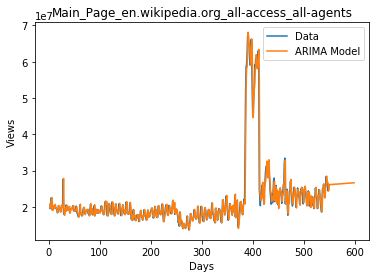

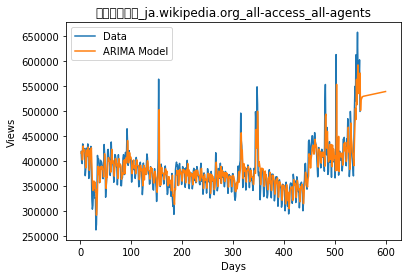

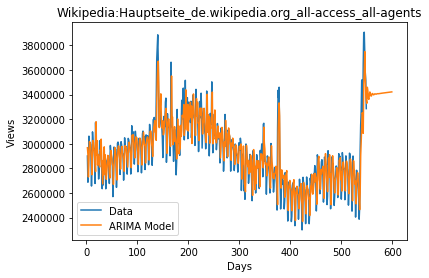

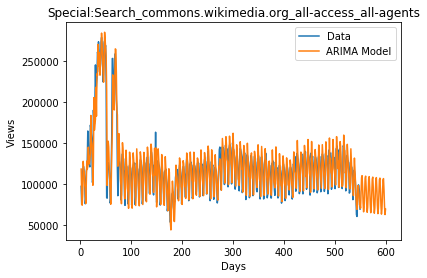

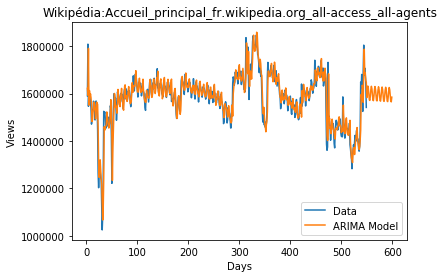

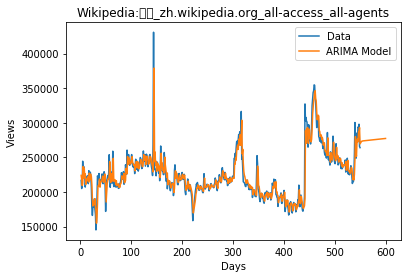

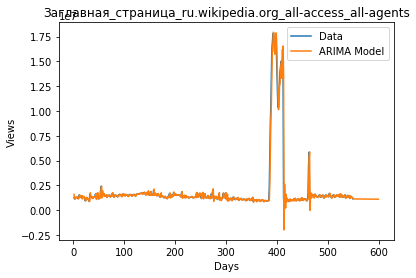

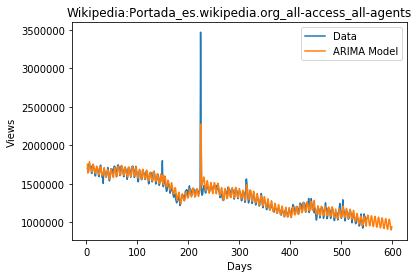

In [14]:
from statsmodels.tsa.arima_model import ARIMA
import warnings

cols = train.columns[1:-1]
for key in top_pages:
    data = np.array(train.loc[top_pages[key],cols],'f')
    result = None
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        try:
            arima = ARIMA(data,[2,1,4])
            result = arima.fit(disp=False)                      #学習
        except:
            try:
                arima = ARIMA(data,[2,1,2])                    
                result = arima.fit(disp=False)                  #学習
            except:
                print(train.loc[top_pages[key],'Page'])
                print('\tARIMA failed')
    #print(result.params)
    pred = result.predict(2,599,typ='levels')               #予測
    x = [i for i in range(600)]
    i=0

    plt.plot(x[2:len(data)],data[2:] ,label='Data')           #元データ
    plt.plot(x[2:],pred,label='ARIMA Model')                #予測モデルプロット
    plt.title(train.loc[top_pages[key],'Page'])
    plt.xlabel('Days')
    plt.ylabel('Views')
    plt.legend()
    plt.show()

## ARIMAモデルは、信号の週ごとの部分構造を予測できる場合があります。これは良いことです。他の場合では、それは単に線形適合を与えるようです。これは潜在的に非常に便利です。ただし、ARIMAモデルをデータセット全体に盲目的に適用した場合、結果は基本的な中央値モデルを使用した場合ほど良くありません。それはまだいくつかの興味深い特性を持っているようですので、おそらくこれを別のモデルと組み合わせてより良い結果を得ることができます。または、おそらくARIMAが他のモデルよりもうまく機能すると思われるデータのサブセットを見つけることができます。残念ながら、statsmodelsのARIMAクラスは非常に遅いため、これを実行するには、おそらくこれを並列化する必要があります。

In [15]:
result

In [16]:
result.summary()

/Users/adachi-yuya/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:1455: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/Users/adachi-yuya/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/adachi-yuya/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/adachi-yuya/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  549
Model:                 ARIMA(2, 1, 4)   Log Likelihood               -7088.693
Method:                       css-mle   S.D. of innovations          96229.951
Date:                Wed, 19 Aug 2020   AIC                          14193.387
Time:                        10:48:45   BIC                          14227.852
Sample:                             1   HQIC                         14206.856
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1309.6430      1.228  -1066.647      0.000   -1312.050   -1307.237
ar.L1.D.y      1.2441      0.001   1066.636      0.000       1.242       1.246
ar.L2.D.y     -1.0000        nan        nan        nan         nan         nan
ma.L1.D.y     -1.8149      0.036    -51.081      0.000      -1.885      -1.745
ma.L2.D.y      1.4105      0.076     18.516      0.000       1.261       1.560
ma.L3.D.y     -0.1985      0.077     -2.594      0.010      -0.348      -0.048
ma.L4.D.y     -0.2961      0.037     -7.976      0.000      -0.369      -0.223
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6221           -0.7830j            1.0000           -0.1431
AR.2            0.6221           +0.7830j            1.0000            0.1431
MA.1            0.6241           -0.7825j            1.0009           -0.1429
MA.2            0.6241           +0.7825j            1.0009            0.1429
MA.3            1.1123           -0.0000j            1.1123           -0.0000
MA.4           -3.0309           -0.0000j            3.0309           -0.5000
-----------------------------------------------------------------------------
"""

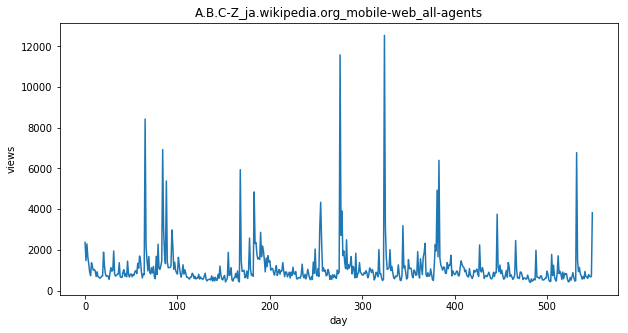

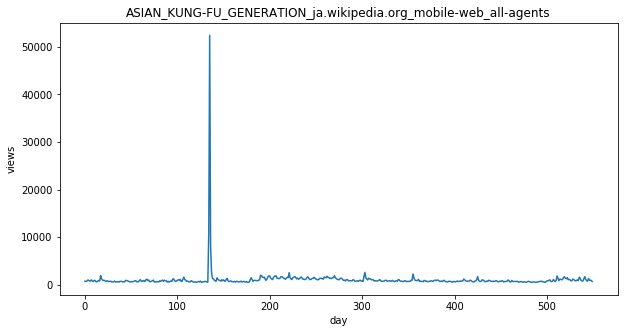

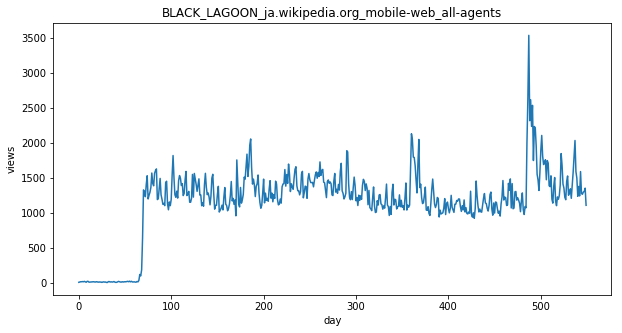

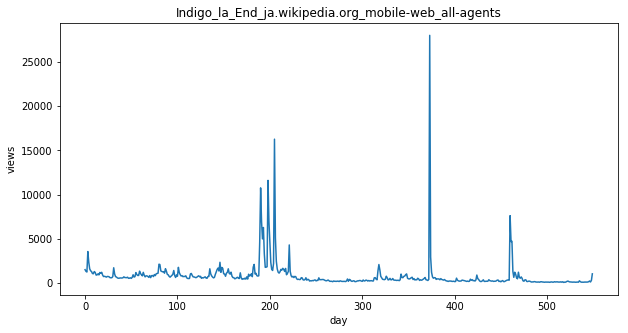

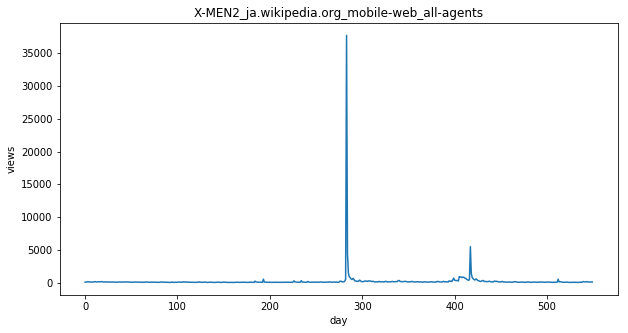

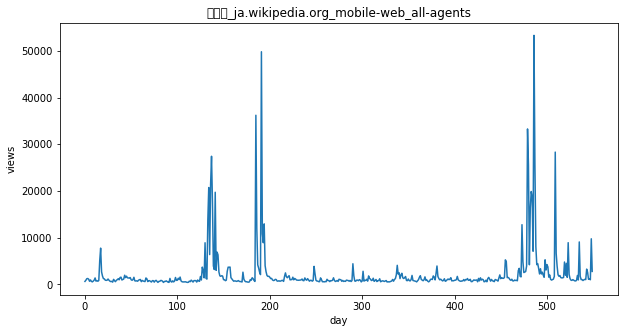

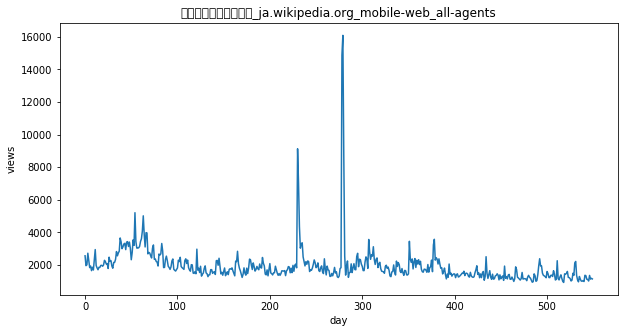

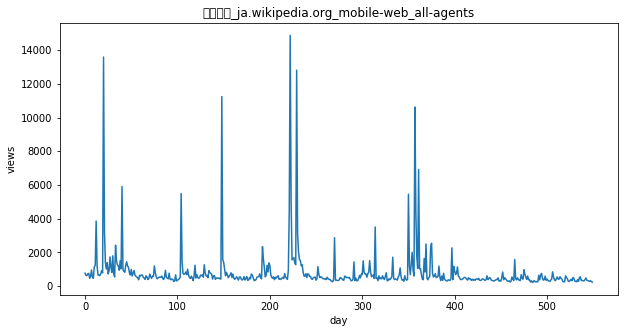

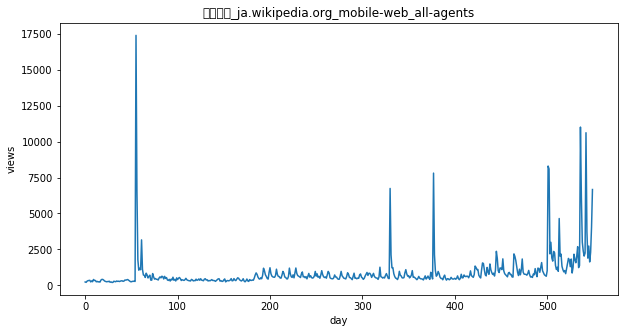

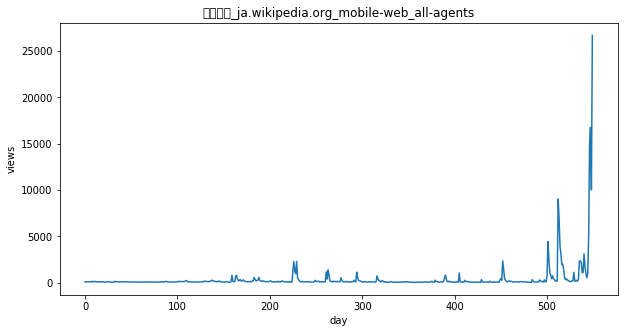

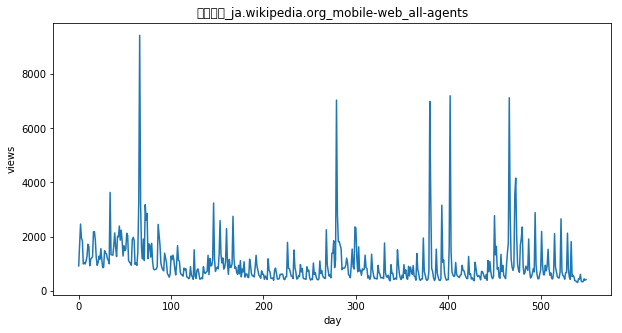

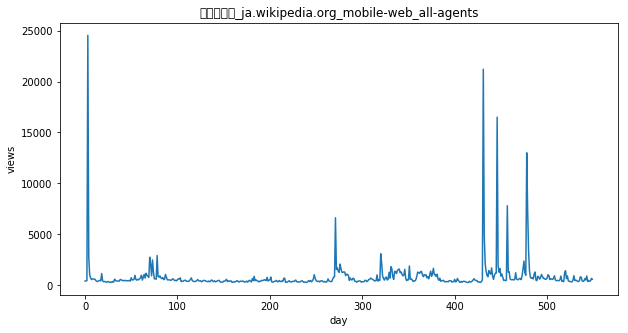

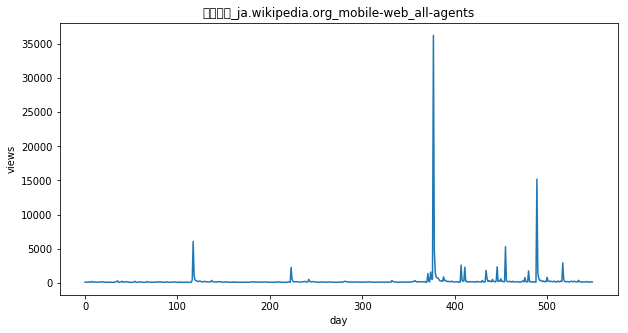

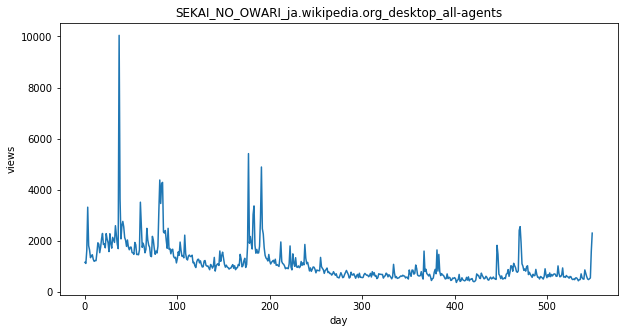

In [17]:
idx = [1, 5, 10, 50, 100, 250,500, 750,1001,1500,2000,3000,4000,5000]
for i in idx:
    plot_entry('ja',i)

In [18]:
train_ja = train[train['lang'] == "ja"]
train_ja.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,lang
55714,A-Studio_ja.wikipedia.org_mobile-web_all-agents,102.0,115.0,851.0,568.0,294.0,229.0,145.0,126.0,173.0,...,1032.0,283.0,170.0,157.0,115.0,117.0,140.0,155.0,159.0,ja
55715,A.B.C-Z_ja.wikipedia.org_mobile-web_all-agents,2366.0,1473.0,2292.0,1644.0,1315.0,905.0,733.0,1367.0,1152.0,...,940.0,679.0,678.0,597.0,785.0,721.0,667.0,698.0,3824.0,ja
55716,ACE_OF_SPADES_ja.wikipedia.org_mobile-web_all-...,63.0,68.0,53.0,81.0,60.0,56.0,48.0,38.0,47.0,...,216.0,200.0,170.0,98.0,88.0,105.0,98.0,80.0,181.0,ja
55717,ALEXANDER_ja.wikipedia.org_mobile-web_all-agents,297.0,264.0,286.0,456.0,500.0,256.0,262.0,402.0,271.0,...,667.0,6941.0,1415.0,922.0,777.0,652.0,579.0,554.0,400.0,ja
55718,ALL_OUT!!_ja.wikipedia.org_mobile-web_all-agents,0.0,3.0,1.0,1.0,0.0,0.0,1.0,2.0,1.0,...,1460.0,1244.0,1315.0,904.0,939.0,2062.0,1324.0,2254.0,1089.0,ja


In [19]:
train_ja["Total"] = train_ja.iloc[:, 1:-2].sum(axis=1)
train_ja.head()

/Users/adachi-yuya/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,lang,Total
55714,A-Studio_ja.wikipedia.org_mobile-web_all-agents,102.0,115.0,851.0,568.0,294.0,229.0,145.0,126.0,173.0,...,283.0,170.0,157.0,115.0,117.0,140.0,155.0,159.0,ja,261072.0
55715,A.B.C-Z_ja.wikipedia.org_mobile-web_all-agents,2366.0,1473.0,2292.0,1644.0,1315.0,905.0,733.0,1367.0,1152.0,...,679.0,678.0,597.0,785.0,721.0,667.0,698.0,3824.0,ja,602818.0
55716,ACE_OF_SPADES_ja.wikipedia.org_mobile-web_all-...,63.0,68.0,53.0,81.0,60.0,56.0,48.0,38.0,47.0,...,200.0,170.0,98.0,88.0,105.0,98.0,80.0,181.0,ja,151921.0
55717,ALEXANDER_ja.wikipedia.org_mobile-web_all-agents,297.0,264.0,286.0,456.0,500.0,256.0,262.0,402.0,271.0,...,6941.0,1415.0,922.0,777.0,652.0,579.0,554.0,400.0,ja,750623.0
55718,ALL_OUT!!_ja.wikipedia.org_mobile-web_all-agents,0.0,3.0,1.0,1.0,0.0,0.0,1.0,2.0,1.0,...,1244.0,1315.0,904.0,939.0,2062.0,1324.0,2254.0,1089.0,ja,157423.0


In [20]:
train_ja.sort_values(by="Total", ascending=False)

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,lang,Total
120336,メインページ_ja.wikipedia.org_all-access_all-agents,418594.0,415069.0,419023.0,398771.0,394907.0,434303.0,428343.0,420964.0,424638.0,...,565656.0,596148.0,657977.0,577249.0,540661.0,568040.0,602701.0,499566.0,ja,210254229.0
86431,メインページ_ja.wikipedia.org_desktop_all-agents,286962.0,284409.0,285051.0,243782.0,235765.0,296575.0,289924.0,281141.0,284218.0,...,276147.0,284671.0,372982.0,297016.0,281325.0,225793.0,223610.0,198956.0,ja,133948459.0
123025,特別:検索_ja.wikipedia.org_all-access_all-agents,130137.0,127160.0,127107.0,110931.0,113740.0,138393.0,140695.0,135488.0,133354.0,...,110146.0,111404.0,197475.0,119231.0,121687.0,105935.0,207120.0,95732.0,ja,70221197.0
89202,特別:検索_ja.wikipedia.org_desktop_all-agents,128002.0,125094.0,124740.0,108220.0,110752.0,136064.0,138679.0,133135.0,130998.0,...,107614.0,108519.0,195193.0,116727.0,119396.0,103415.0,204519.0,93140.0,ja,69122066.0
57309,メインページ_ja.wikipedia.org_mobile-web_all-agents,107166.0,106509.0,108668.0,126143.0,129324.0,112185.0,112457.0,113111.0,112903.0,...,117085.0,122186.0,105989.0,105007.0,101075.0,108487.0,111605.0,122191.0,ja,66336931.0
119609,特別:最近の更新_ja.wikipedia.org_all-access_all-agents,85510.0,80197.0,70844.0,29913.0,45476.0,44932.0,34744.0,82199.0,82641.0,...,9425.0,10557.0,12828.0,49461.0,17113.0,10061.0,10583.0,9276.0,ja,17653515.0
88897,特別:最近の更新_ja.wikipedia.org_desktop_all-agents,85432.0,80122.0,70757.0,29864.0,45397.0,44850.0,34634.0,82119.0,82563.0,...,9381.0,10508.0,12726.0,49373.0,17043.0,9966.0,10509.0,9194.0,ja,17618427.0
119625,真田信繁_ja.wikipedia.org_all-access_all-agents,2211.0,2097.0,2650.0,3209.0,2615.0,2270.0,2270.0,2339.0,3471.0,...,30691.0,16465.0,9946.0,10390.0,8074.0,8307.0,49584.0,13825.0,ja,10779214.0
123292,特別:外部リンク検索_ja.wikipedia.org_all-access_all-agents,12545.0,51909.0,45053.0,3470.0,665.0,46916.0,70991.0,52123.0,19378.0,...,40061.0,17468.0,16606.0,6910.0,26617.0,7634.0,3151.0,28854.0,ja,10302337.0
89463,特別:外部リンク検索_ja.wikipedia.org_desktop_all-agents,12545.0,51907.0,45053.0,3470.0,665.0,46916.0,70991.0,52123.0,19378.0,...,40061.0,17468.0,16606.0,6910.0,26617.0,7634.0,3151.0,28854.0,ja,10299063.0


## topic
- [アクセス1位メインページ？](https://ja.wikipedia.org/wiki/%E3%83%A1%E3%82%A4%E3%83%B3%E3%83%9A%E3%83%BC%E3%82%B8)
- 人物1位_星野源、女性1位_高畑充希,アーティスト1位_ワンオク　団体1位_山口組

## またkaggle担当が回ってきたら
- 様々なフィルターでのEDA
  - ja
  - NBA選手
  - 正規表現の勉強
  - 移動平均での最大
  - 時事ニュースとのトレンド（オリンピック・ワールドカップ・北朝鮮核ミサイル・国政選挙・藤井聡太・AlphaZero・芸能人不倫など）

In [25]:
train_ja[train_ja["Page"].str.contains("星野源")]

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,lang,Total
58097,星野源_ja.wikipedia.org_mobile-web_all-agents,3500.0,5576.0,4052.0,5350.0,4345.0,3008.0,2705.0,2751.0,3942.0,...,58813.0,42593.0,33694.0,35392.0,31769.0,29954.0,31569.0,150601.0,ja,7379017.0
60519,恋_(星野源の曲)_ja.wikipedia.org_mobile-web_all-agents,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2958.0,2240.0,1757.0,1576.0,1651.0,1724.0,1960.0,5985.0,ja,106094.0
87293,星野源_ja.wikipedia.org_desktop_all-agents,1257.0,1600.0,1540.0,1481.0,1250.0,1100.0,979.0,1069.0,1270.0,...,15317.0,12279.0,14865.0,13027.0,11306.0,10333.0,9644.0,19157.0,ja,2069227.0
90058,恋_(星野源の曲)_ja.wikipedia.org_desktop_all-agents,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1474.0,1642.0,2161.0,1814.0,1559.0,985.0,958.0,1764.0,ja,68220.0
121159,星野源_ja.wikipedia.org_all-access_all-agents,4768.0,7203.0,5613.0,6859.0,5618.0,4121.0,3693.0,3831.0,5235.0,...,74681.0,55346.0,48812.0,48608.0,43404.0,40525.0,41444.0,170517.0,ja,9491885.0
123634,恋_(星野源の曲)_ja.wikipedia.org_all-access_all-agents,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4465.0,3924.0,3933.0,3405.0,3224.0,2728.0,2937.0,7819.0,ja,175677.0
134421,星野源_ja.wikipedia.org_all-access_spider,5.0,11.0,7.0,6.0,11.0,7.0,6.0,5.0,16.0,...,7003.0,5013.0,4186.0,3969.0,3599.0,3851.0,3863.0,15303.0,ja,720472.0
136883,恋_(星野源の曲)_ja.wikipedia.org_all-access_spider,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,269.0,313.0,168.0,186.0,231.0,135.0,190.0,564.0,ja,10579.0


In [28]:
train_bekki = train_ja[train_ja["Page"].str.contains("ベッキー")]
train_bekki.loc[:, "2015-12-25": "2016-01-15"]

,2015-12-25,2015-12-26,2015-12-27,2015-12-28,2015-12-29,2015-12-30,2015-12-31,2016-01-01,2016-01-02,2016-01-03,...,2016-01-06,2016-01-07,2016-01-08,2016-01-09,2016-01-10,2016-01-11,2016-01-12,2016-01-13,2016-01-14,2016-01-15
57551,1282.0,1238.0,3866.0,1646.0,1454.0,4960.0,9177.0,1749.0,1759.0,2312.0,...,31624.0,164718.0,99997.0,54700.0,53796.0,26900.0,20296.0,19070.0,15332.0,13829.0
86712,419.0,367.0,690.0,451.0,563.0,1379.0,2980.0,466.0,574.0,896.0,...,16344.0,86361.0,54564.0,27470.0,20566.0,13792.0,13181.0,13848.0,8871.0,7129.0
120587,1710.0,1615.0,4585.0,2107.0,2033.0,6380.0,12218.0,2231.0,2350.0,3228.0,...,48168.0,251945.0,155173.0,82555.0,74705.0,40868.0,33588.0,33044.0,24308.0,21068.0
133841,101.0,112.0,274.0,206.0,100.0,546.0,2184.0,199.0,127.0,201.0,...,4309.0,18881.0,11428.0,6112.0,5626.0,2615.0,1824.0,2124.0,1173.0,1305.0
